# Nobel Twin Familial Cirrhosis Combined Machine Learning Analysis
This notebook looks to combine the best performing serum and fecal features to create a combined metabolome model. In the combined feature set there are 50 fecal metabolites from Songbird Top25+Bot25 and 49 serum metabolites from the selected features (0.05 feat imp cutoff). To improve the model, I will only be using feature importance cutoffs.

**Author: Tobin Groth (tgroth@ucsd.edu)**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import qiime2
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pylab as pl
import qiime2
import os


os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/multiomic_analysis')

In [5]:
#loading in metadata
meta = pd.read_csv('../metadata-matched.tsv',sep='\t',index_col=0)
meta.head(3)

,ATTRIBUTE_AgeInYears,ATTRIBUTE_BarcodeSequence,ATTRIBUTE_BiologicalSex,ATTRIBUTE_ChromatographyAndPhase,ATTRIBUTE_ComorbidityListDOIDIndex,ATTRIBUTE_Country,ATTRIBUTE_DOIDCommonName,ATTRIBUTE_DOIDOntologyIndex,ATTRIBUTE_DepthorAltitudeMeters,ATTRIBUTE_Description,...,ATTRIBUTE_waist_circumference_cm,ATTRIBUTE_water_lot,ATTRIBUTE_wbc,ATTRIBUTE_weight,ATTRIBUTE_weight_units,ATTRIBUTE_well_description,ATTRIBUTE_well_id,ATTRIBUTE_zygocity,ATTRIBUTE_zygoticity,filename
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,54,TCATGGCCTCCG,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,98,RNBF9925,8,80.6,kg,Loomba_Twin_Plate_2_TW.CO.002_E2,E2,2,2.0,TW-CO-002_RC4_01_35874.mzXML
TW-BT-001,49,CACACAAAGTCA,female,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,92,RNBF9925,8.5,80.8,kg,Loomba_Twin_Plate_2_TW.BT.001_E10,E10,1,1.0,TW-BT-001_RH12_01_35942.mzXML
TW-CA-002,61,TCCGGCGGGCAA,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,115,RNBF9925,6.2,99.7,kg,Loomba_Twin_Plate_2_TW.CA.002_B10,B10,1,1.0,TW-CA-002_RH6_01_35936.mzXML


In [3]:
#loading in the combined scaled feature table
combined_tablepd = pd.read_csv('./feature_tables/combined-ft-scaled.tsv',sep='\t',index_col=0)
combined_tablepd.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,d49b933216498ccb080d8aa7ce5d3902,35def52a34fbd75d08ef99a87b5251da,c105049a81dcab19d86f141a691ab5fb,28a02f8e5fcae1d3b8d41678bf1276fd,2ed762ffceda0c2dc67e9ae95d1fb858,178929d3e7f149a19dbd6b0edc66633b,076048a24f2e01c5f6b07bfcde6bbcd5,d2db4c8806f5f6a40fee293cb4f88f7d,7d77e5a1807f89e7ee7cf109a12d0048,8e1376b2f43f2b926aa075c7f8c32783
TW-CO-002,1.057551,0.713690,0.101371,0.133053,-0.286215,-0.318617,0.065534,-0.279881,0.117167,-0.301339,...,-0.156162,-0.199077,-0.213105,-0.196710,-0.211812,-0.192874,-0.213467,-0.144658,-0.350927,-0.184709
TW-BT-001,4.324877,3.217350,-0.021519,3.134937,6.154245,-0.316190,4.300775,0.274048,0.371661,-0.301339,...,8.260510,-0.199077,0.179278,2.081977,-0.211812,-0.192874,1.263011,-0.144658,-0.350927,0.189496
TW-CA-002,-0.503911,0.362269,-0.075956,1.604561,0.699963,-0.318680,0.459769,0.823721,0.202315,-0.280759,...,-0.156162,-0.199077,0.227008,-0.196710,-0.211812,-0.192874,0.109264,-0.144658,-0.350927,9.853495


# 1. Building Baseline Models

## 1a. Cross Validating and Training on G1P+G3P 

In [6]:
# get all the samples that are either in group G1P G3P
samples_train = ([idx for idx in meta[meta.ATTRIBUTE_groups=='G1P'].index]
            + [idx for idx in meta[meta.ATTRIBUTE_groups=='G3P'].index])
exp_train = meta.loc[samples_train][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_train.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
print(exp_train.groups.value_counts())
print(exp_train.adv_fibrosis.value_counts())

G1P    48
G3P    22
Name: groups, dtype: int64
0                         44
1                         22
Missing: Not collected     4
Name: adv_fibrosis, dtype: int64


**Can see the 4 Missing: Not collected individuals are from G1P and therefore are 0 for AF**


In [7]:
#preparing training data for base model
x_train_base = combined_tablepd.loc[exp_train.index]
#label encoder
y_train_base = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_base.append(1)
    #values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_base.append(0)
y_train_base = np.array(y_train_base)
print(len(x_train_base.index))
print(len(y_train_base))

70
70


In [8]:
#creating method for cross validating model by plotting ROC
#cf==0 for log reg, cf==1 for RF
def cross_val_roc(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot ROC curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.3, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        pl.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' %  roc_auc)

    pl.plot([0, 1], [0, 1], '--', color=(0.6,0.6,0.6), label='Luck')
    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pl.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    pl.xlim([-0.05,1.05])
    pl.ylim([-0.05,1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    return pl

In [9]:
#creating method for cross validating model by plotting Precision-Recall curve
#cf==0 for log reg, cf==1 for RF
def cross_val_pr(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.metrics import precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot precision-recall curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.4, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_precision = 0.0
    mean_recall = np.linspace(1, 0, 100)
    all_precision = []

    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute precision-recall curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y_train[test], probas_[:,1])
        #fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        rev_recall = recall[::-1]
        rev_precision = precision[::-1]
        mp = np.interp(mean_recall, rev_recall, rev_precision)
        #print(mp)
        mean_precision += mp
        #mean_precision[0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        plt.plot(recall, precision, lw=1, label='Precision-Recall (area = %0.2f)' %  pr_auc)

    #plt.plot([0, 1], [1, 0], '--', color=(0.6,0.6,0.6), label='Luck')

    mean_precision /= cv.get_n_splits()
    #mean_precision[-1] = 1.0
    mean_auc = auc(mean_recall, mean_precision)
    #print(mean_recall)
    #print(mean_precision)
    plt.plot(mean_recall, mean_precision, 'k--',
            label='Mean Precision-Recall (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    #plt.legend(loc="lower right")
    return plt

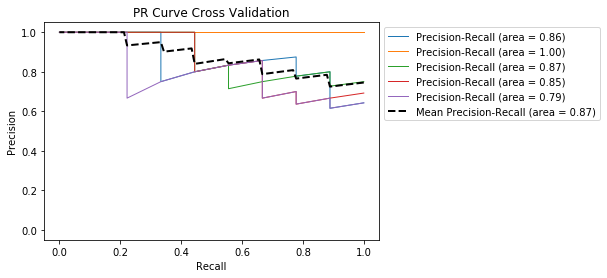

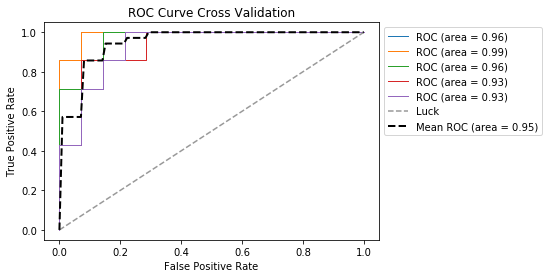

In [10]:
#plotting Precision-recall for Log Reg
lr_fig = cross_val_pr(0,x_train_base,y_train_base,'PR Curve Cross Validation')
lr_fig.savefig('./ml_analysis/combined_figures/lr_base_cv_pr.pdf',bbox_inches='tight')

lr_fig = cross_val_roc(0,x_train_base,y_train_base,'ROC Curve Cross Validation')
lr_fig.savefig('./ml_analysis/combined_figures/lr_base_cv_roc.pdf',bbox_inches='tight')

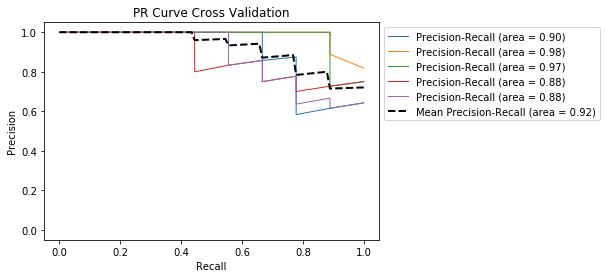

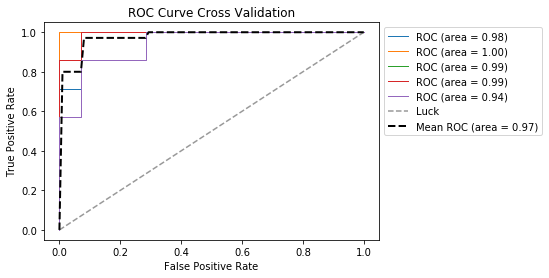

In [11]:
#plott prevision recall for Random Forest
rf_fig = cross_val_pr(1,x_train_base,y_train_base,'PR Curve Cross Validation')
rf_fig.savefig('./ml_analysis/combined_figures/rf_base_cv_pr.pdf',bbox_inches='tight')

rf_fig = cross_val_roc(1,x_train_base,y_train_base,'ROC Curve Cross Validation')
rf_fig.savefig('./ml_analysis/combined_figures/rf_base_cv_roc.pdf',bbox_inches='tight')

In [12]:
#training Log Reg on training data
base_lr = LogisticRegression(random_state=0,max_iter=200)
base_lr.fit(x_train_base, y_train_base)

LogisticRegression(max_iter=200, random_state=0)

In [13]:
#training RF on training data
base_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
base_rf.fit(x_train_base, y_train_base)
base_rf.oob_score_

0.8857142857142857

## 1b. Testing models on G3R

In [14]:
# get all the samples that are G3R
samples_test = [idx for idx in meta[meta.ATTRIBUTE_groups=='G3R'].index if idx in combined_tablepd.index]
exp_test = meta.loc[samples_test][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_test.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
#have to drop Missing: Not collected values
exp_test = exp_test[exp_test.adv_fibrosis != 'Missing: Not collected']
print(exp_test.adv_fibrosis.value_counts())

0    21
1     7
Name: adv_fibrosis, dtype: int64


In [15]:
# Preparing the test data for BAB and SB
x_test_base = combined_tablepd.loc[exp_test.index]
y_test_base = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_base.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_base.append(0)
y_test_base = np.array(y_test_base)
print(len(x_test_base))
print(len(y_test_base))

28
28


In [16]:
#plotting Precision Recall curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_pr(result,title,cv=True):
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    #ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_recall = np.linspace(1, 0, 100)
    for cls in classes:
        precisions = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
                rev_recall = recall[::-1]
                rev_precision = precision[::-1]
                mean_precision = np.interp(mean_recall, rev_recall, rev_precision)
                precisions.append(mean_precision)
                precisions[-1][0] = 0.0
                pr_auc = metrics.auc(mean_recall, mean_precision)
                aucs.append(pr_auc)

            mean_precision = np.mean(precisions, axis=0)
            #mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_recall, mean_precision, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_precision = np.std(precisions, axis=0)
            precisions_upper = np.minimum(mean_precision + std_precision, 1)
            precisions_lower = np.maximum(mean_precision - std_precision, 0)
            ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
            pr_auc = auc(recall, precision)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(recall, 0, 0), np.insert(precision, 0, 0), label='{0} ({1:.2f})'.format(cls, pr_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else pr_auc
    return plt

In [17]:
#plotting ROC curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_roc(result,title,cv=True):    
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = metrics.roc_curve(y_true.astype(int), df[cls])
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = metrics.auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else roc_auc
    return plt

In [18]:
#testing the logistic regression base model
result_base_lr = pd.DataFrame(base_lr.predict_proba(x_test_base))
result_base_lr.columns = base_lr.classes_
result_base_lr['Y_TRUE'] = y_test_base
result_base_lr['CV'] = 0

Average precision-recall score: 0.34


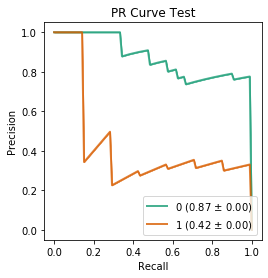

In [19]:
fig_base_lr = plot_result_pr(result_base_lr,'PR Curve Test')
fig_base_lr.savefig('./ml_analysis/combined_figures/lr_base_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_base, base_lr.predict(x_test_base))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.57


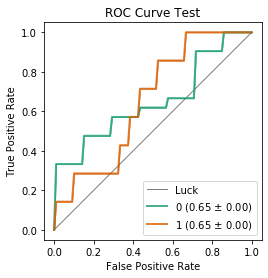

In [20]:
fig_base_lr = plot_result_roc(result_base_lr,'ROC Curve Test')
fig_base_lr.savefig('./ml_analysis/combined_figures/lr_base_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_base, base_lr.predict(x_test_base))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [21]:
#testing the random forest base model
result_base_rf = pd.DataFrame(base_rf.predict_proba(x_test_base))
result_base_rf.columns = base_rf.classes_
result_base_rf['Y_TRUE'] = y_test_base
result_base_rf['CV'] = 0

Average precision-recall score: 0.24


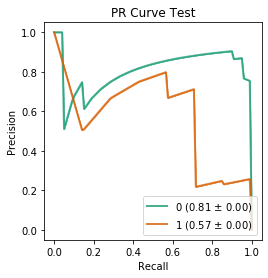

In [22]:
fig_base_rf = plot_result_pr(result_base_rf,'PR Curve Test')
fig_base_rf.savefig('./ml_analysis/combined_figures/rf_base_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_base, base_rf.predict(x_test_base))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.29


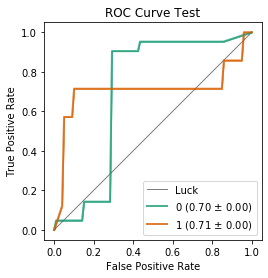

In [24]:
fig_base_rf = plot_result_roc(result_base_rf,'ROC Curve Test')
fig_base_rf.savefig('./ml_analysis/combined_figures/rf_base_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_base, base_rf.predict(x_test_base))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

**Next we will use feature importance to select features to see if that can improve our model**

In [25]:
# extracting the important features from our classifier
base_fimp1 = pd.Series(base_rf.feature_importances_).sort_values(ascending=False)
base_fimp1 = base_fimp1.to_frame()
base_fimp1.columns = ['imp_score']
base_fimp1.head(5)

,imp_score
14,0.068705
36,0.056421
10,0.052693
32,0.043654
34,0.043020


In [26]:
# extracting the features that have a feature importance over the threshold of 0.01
top_feat1 = list(base_fimp1[base_fimp1['imp_score']>0.005].index)
print('There are %d features with importance >0.005' %len(top_feat1))

There are 44 features with importance >0.005


## 2. Building New Models Using Selected Features

### 2a. CV/Train model on G1P+G3P

In [27]:
#getting samples to 
exp_train.groups.value_counts()

G1P    48
G3P    22
Name: groups, dtype: int64

In [29]:
#preparing training data
x_train_feat1 = combined_tablepd.loc[exp_train.index]
x_train_feat1 = x_train_feat1.iloc[:,top_feat1]
#label encoder
y_train_feat1 = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_feat1.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_feat1.append(0)
y_train_feat1 = np.array(y_train_feat1)
#ensuring we have correct samples x features
print(x_train_feat1.shape)
print(len(y_train_feat1))

(70, 44)
70


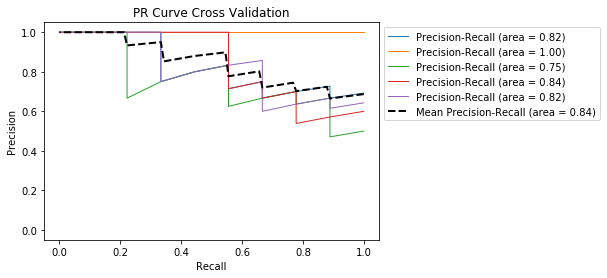

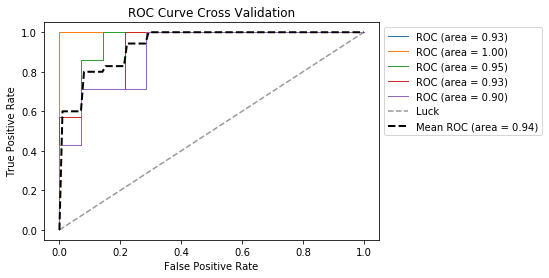

In [30]:
fig_lr = cross_val_pr(0,x_train_feat1,y_train_feat1,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_selected_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_feat1,y_train_feat1,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_selected_cv_roc.pdf',bbox_inches='tight')

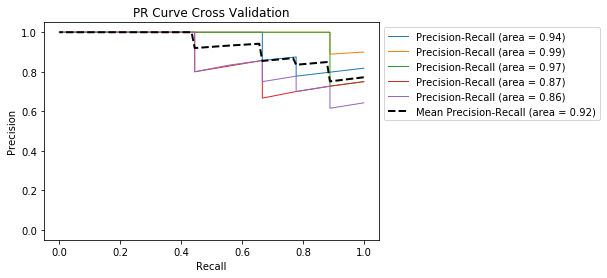

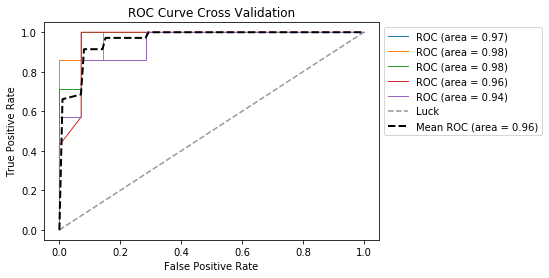

In [31]:
fig_rf = cross_val_pr(1,x_train_feat1,y_train_feat1,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_selected_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_feat1,y_train_feat1,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_selected_cv_roc.pdf',bbox_inches='tight')


In [32]:
#training Log Reg on training data
feat1_lr = LogisticRegression(random_state=0,max_iter=200)
feat1_lr.fit(x_train_feat1, y_train_feat1)

LogisticRegression(max_iter=200, random_state=0)

In [33]:
#training RF on training data
feat1_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
feat1_rf.fit(x_train_feat1, y_train_feat1)
feat1_rf.oob_score_

0.8857142857142857

### 2b. Testing Models on G3R Samples

In [34]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [35]:
# Preparing the test data
x_test_feat1 = combined_tablepd.loc[exp_test.index]
x_test_feat1 = x_test_feat1.iloc[:,top_feat1]
y_test_feat1 = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_feat1.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_feat1.append(0)
y_test_feat1 = np.array(y_test_feat1)
print(x_test_feat1.shape)
print(len(y_test_feat1))

(28, 44)
28


In [36]:
#testing log reg
result_feat1_lr = pd.DataFrame(feat1_lr.predict_proba(x_test_feat1))
result_feat1_lr.columns = feat1_lr.classes_
result_feat1_lr['Y_TRUE'] = y_test_feat1
result_feat1_lr['CV'] = 0

Average precision-recall score: 0.28


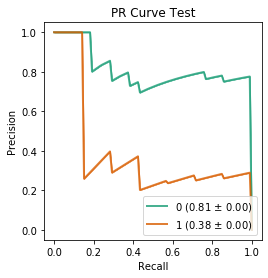

In [37]:
fig_feat1_lr = plot_result_pr(result_feat1_lr,'PR Curve Test')
fig_feat1_lr.savefig('ml_analysis/combined_figures/lr_selected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat1, feat1_lr.predict(x_test_feat1))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.43


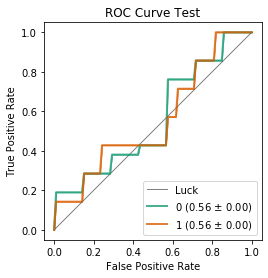

In [38]:
fig_feat1_lr = plot_result_roc(result_feat1_lr,'ROC Curve Test')
fig_feat1_lr.savefig('ml_analysis/combined_figures/lr_selected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat1, feat1_lr.predict(x_test_feat1))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [39]:
#testing the random forest selected feature model
result_feat1_rf = pd.DataFrame(feat1_rf.predict_proba(x_test_feat1))
result_feat1_rf.columns = feat1_rf.classes_
result_feat1_rf['Y_TRUE'] = y_test_feat1
result_feat1_rf['CV'] = 0

Average precision-recall score: 0.26


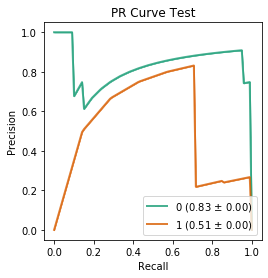

In [40]:
fig_feat1_rf = plot_result_pr(result_feat1_rf,'PR Curve Test')
fig_feat1_rf.savefig('ml_analysis/combined_figures/rf_selected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat1, feat1_rf.predict(x_test_feat1))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.29


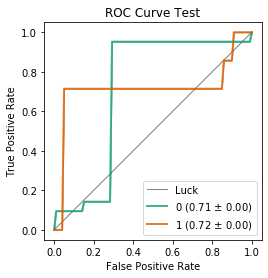

In [41]:
fig_feat1_rf = plot_result_roc(result_feat1_rf,'ROC Curve Test')
fig_feat1_rf.savefig('ml_analysis/combined_figures/rf_selected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat1, feat1_rf.predict(x_test_feat1))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [42]:
## extracting the important features from our classifier
base_fimp2 = pd.Series(feat1_rf.feature_importances_).sort_values(ascending=False)
base_fimp2 = base_fimp2.to_frame()
base_fimp2.columns = ['imp_score']
base_fimp2.shape

(44, 1)

In [43]:
# extracting the features that have a feature importance over the threshold of 0.02
top_feat2 = list(base_fimp2[base_fimp2['imp_score']>0.02].index)
top_feat2 = x_test_feat1.iloc[:,top_feat2].columns
print('There are %d features with importance >0.02' %len(top_feat2))

There are 16 features with importance >0.02


## Exporting Feature Importance

In [11]:
feat_info = pd.read_csv('classified-feature-data.tsv',sep='\t')
feat_info.head(3)

,id,#featureID,csi_smiles,ms2_smiles,ms2_compound,ms2_adduct,table_number,smiles,annotation_type,kingdom,superclass,class,subclass,direct_parent
0,da5dc9007216de85908619b0d8d6c065,395,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,NaN,NaN,NaN,1,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
1,b5a7b5651a9dd589ebba875701732d11,4673,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,NaN,NaN,NaN,1,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
2,5a307cd7a787f5b3269a7d6c0175fb2e,2513,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,NaN,NaN,NaN,1,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified


In [50]:
feat1_imp = pd.Series(feat1_rf.feature_importances_).to_frame()
feat1_imp.columns = ['feat importance']

In [51]:
#going through table to find featureID
id_col = []
hash_col = []
king_col = []
supclass_col = []
class_col = []
subclass_col = []
dp_col = []
sb_col = []
for idx in feat1_imp.index:
    hash_id = serum_tablepd.columns[idx]
    hash_col.append(hash_id)
    fbmn_id = feat_info[feat_info.id==hash_id]['#featureID'].iloc[0]
    taxa = feat_info.loc[idx][['kingdom','superclass','class','subclass','direct_parent']]
    king_col.append(taxa[0])#+','+taxa[1]+','+taxa[2]+','+taxa[3]+','+taxa[4]
    supclass_col.append(taxa[1])
    class_col.append(taxa[2])
    subclass_col.append(taxa[3])
    dp_col.append(taxa[4])
    id_col.append(fbmn_id)

In [54]:
feat1_imp['hashedID'] = hash_col
feat1_imp['featueID'] = id_col
feat1_imp['kingdom'] = king_col
feat1_imp['superclass'] = supclass_col
feat1_imp['class'] = class_col 
feat1_imp['subclass'] = subclass_col
feat1_imp['direct_parent'] = dp_col
print(feat1_imp.shape)
feat1_imp.head()

(49, 8)


,feat importance,hashedID,featueID,kingdom,superclass,class,subclass,direct_parent
0,0.064646,0004069a1f2c3f2b14511a4f367e485d,1440,unclassified,unclassified,unclassified,unclassified,unclassified
1,0.023834,0013ada35a72573fde974722d6f46269,762,unclassified,unclassified,unclassified,unclassified,unclassified
2,0.049712,0074f0d3d22016bcdf28ee53c8a5062b,4423,unclassified,unclassified,unclassified,unclassified,unclassified
3,0.056723,012ade16945709e69650957b8fdeb021,4965,Organic compounds,Lipids and lipid-like molecules,Glycerophospholipids,Glycerophosphocholines,1-acyl-sn-glycero-3-phosphocholines
4,0.033299,015bcc773d2fe77d5ddf3533aff00a9f,4725,unclassified,unclassified,unclassified,unclassified,unclassified


In [55]:
feat1_imp.to_csv('./ml_analysis/featImp_analysis/feat1-featimp-taxa.tsv',sep='\t',index=False)

## 3. Building Models Using Further Selected Features

### 3a. CV/Train Model on G1P+G3P data

In [44]:
exp_train.groups.value_counts()

G1P    48
G3P    22
Name: groups, dtype: int64

In [45]:
# preparing training data
x_train_feat2 = combined_tablepd.loc[exp_train.index]
x_train_feat2 = x_train_feat2.loc[:,top_feat2]
# label encoder
y_train_feat2 = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_feat2.append(1)
    # even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_feat2.append(0)
y_train_feat2 = np.array(y_train_feat2)
# ensuring we have correct samples x features
print(x_train_feat2.shape)
print(len(y_train_feat2))

(70, 16)
70


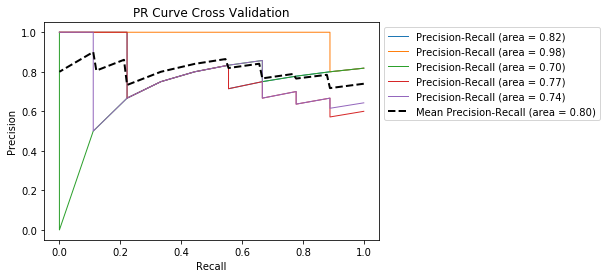

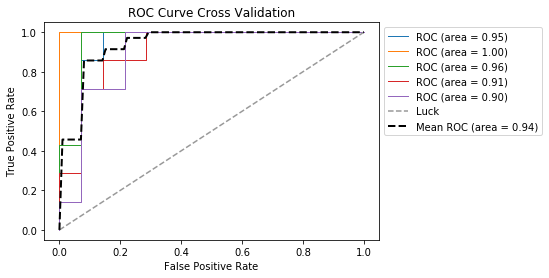

In [46]:
fig_lr = cross_val_pr(0,x_train_feat2,y_train_feat2,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_fselected_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_feat2,y_train_feat2,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_fselected_cv_roc.pdf',bbox_inches='tight')


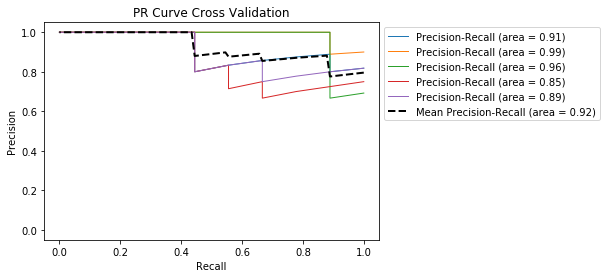

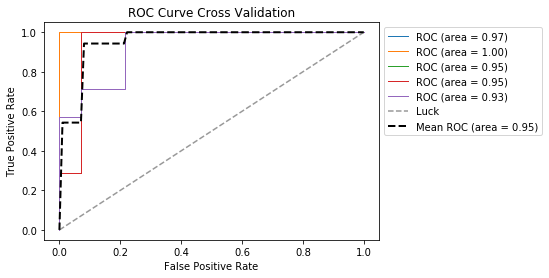

In [47]:
fig_rf = cross_val_pr(1,x_train_feat2,y_train_feat2,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_fselected_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_feat2,y_train_feat2,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_fselected_cv_roc.pdf',bbox_inches='tight')


In [48]:
#training Log Reg on training data
feat2_lr = LogisticRegression(random_state=0,max_iter=200)
feat2_lr.fit(x_train_feat2, y_train_feat2)

LogisticRegression(max_iter=200, random_state=0)

In [49]:
#training RF on training data
feat2_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
feat2_rf.fit(x_train_feat2, y_train_feat2)
feat2_rf.oob_score_

0.9

### 3b. Testing Models on G3R data

In [50]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [51]:
# Preparing the test data
x_test_feat2 = combined_tablepd.loc[exp_test.index]
x_test_feat2 = x_test_feat2.loc[:,top_feat2]
y_test_feat2 = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_feat2.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_feat2.append(0)
y_test_feat2 = np.array(y_test_feat2)
print(x_test_feat2.shape)
print(len(y_test_feat2))

(28, 16)
28


In [52]:
#testing log reg
result_feat2_lr = pd.DataFrame(feat2_lr.predict_proba(x_test_feat2))
result_feat2_lr.columns = feat2_lr.classes_
result_feat2_lr['Y_TRUE'] = y_test_feat2
result_feat2_lr['CV'] = 0

Average precision-recall score: 0.28


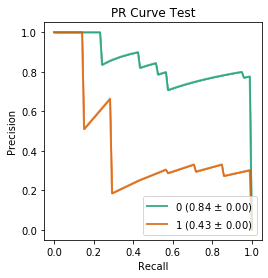

In [53]:
#showing Precision-recall results
fig_feat2_lr = plot_result_pr(result_feat2_lr,'PR Curve Test')
fig_feat2_lr.savefig('ml_analysis/combined_figures/lr_fselected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat2, feat2_lr.predict(x_test_feat2))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.43


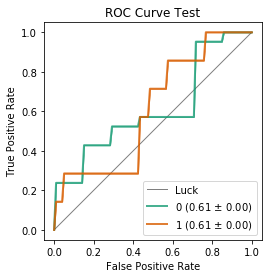

In [54]:
#showing accuracy/ROC results
fig_feat2_lr = plot_result_roc(result_feat2_lr,'ROC Curve Test')
fig_feat2_lr.savefig('ml_analysis/combined_figures/lr_fselected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat2, feat2_lr.predict(x_test_feat2))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [55]:
#testing random forest
result_feat2_rf = pd.DataFrame(feat2_rf.predict_proba(x_test_feat2))
result_feat2_rf.columns = feat2_rf.classes_
result_feat2_rf['Y_TRUE'] = y_test_feat2
result_feat2_rf['CV'] = 0

Average precision-recall score: 0.21


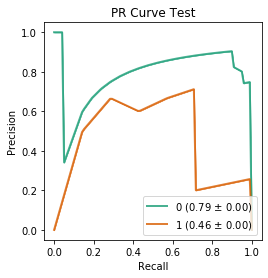

In [56]:
#showing Precision-recall results
fig_feat2_rf = plot_result_pr(result_feat2_rf,'PR Curve Test')
fig_feat2_rf.savefig('ml_analysis/combined_figures/rf_fselected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat2, feat2_rf.predict(x_test_feat2))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.21


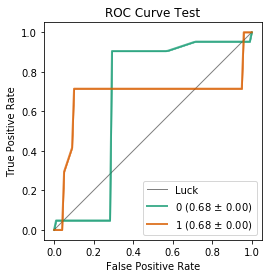

In [57]:
#showing accuracy/ROC results
fig_feat2_rf = plot_result_roc(result_feat2_rf,'ROC Curve Test')
fig_feat2_rf.savefig('ml_analysis/combined_figures/rf_fselected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat2, feat2_rf.predict(x_test_feat2))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

# 4. Adding BMI, Gender and Age to Base Feature Set
Previous analyses have shown that adding in the metadata features above, can strongly improve the performance of the models. The strongest performing combined model was the base feature set.

In [65]:
x_train_comb = pd.concat([x_train_base, clin_feat.loc[exp_train.index]],axis=1)
x_train_comb.gender = pd.factorize(x_train_comb.gender)[0]
print(x_train_comb.shape)
x_train_comb.head(3)

(70, 102)


,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,28a02f8e5fcae1d3b8d41678bf1276fd,2ed762ffceda0c2dc67e9ae95d1fb858,178929d3e7f149a19dbd6b0edc66633b,076048a24f2e01c5f6b07bfcde6bbcd5,d2db4c8806f5f6a40fee293cb4f88f7d,7d77e5a1807f89e7ee7cf109a12d0048,8e1376b2f43f2b926aa075c7f8c32783,gender,bmi,age
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-BS-002,3.159538,1.074491,-0.052525,1.002627,1.081673,-0.318372,-0.498653,-0.449820,0.217149,-0.301339,...,-0.19671,-0.211812,-0.192874,-0.213467,-0.144658,-0.007148,-0.184709,0,28.8,22
TW-BU-002,1.053722,0.363675,-0.064788,-0.359170,-0.275457,-0.316920,-0.509447,-0.669153,-0.037391,-0.289906,...,-0.19671,-0.211812,2.972177,0.104917,-0.144658,0.409404,-0.184709,1,23.7,22
TW-BK-001,-0.448909,-0.847319,-0.130301,0.764087,-0.087591,-0.318441,0.203149,-0.016918,-0.043302,-0.301339,...,-0.19671,-0.211812,-0.192874,-0.213467,-0.144658,-0.350927,-0.184709,1,26.6,60


In [66]:
y_train_comb = []
for idx in x_train_comb.index:
    if meta.loc[idx, 'ATTRIBUTE_adv_fibrosis'] == '1':
        y_train_comb.append(1)
    else:    
        y_train_comb.append(0)
y_train_comb = np.array(y_train_comb)
print(len(y_train_comb))

70


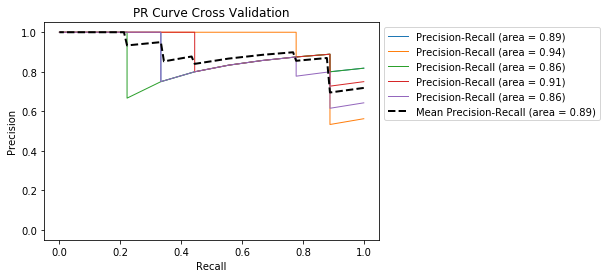

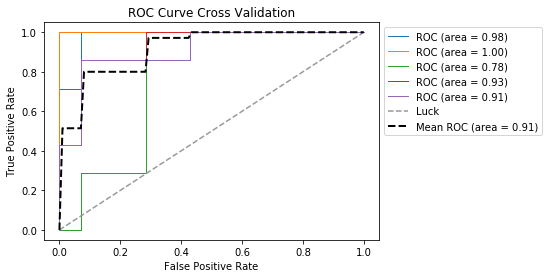

In [67]:
fig_lr = cross_val_pr(0,x_train_comb,y_train_comb,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_base+meta_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_comb,y_train_comb,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_base+meta_cv_roc.pdf',bbox_inches='tight')


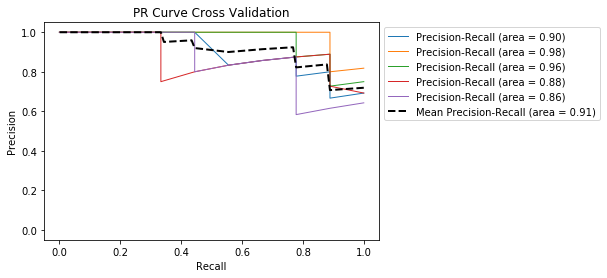

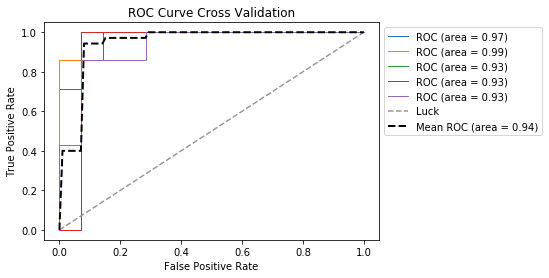

In [68]:
fig_rf = cross_val_pr(1,x_train_comb,y_train_comb,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_base+meta_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_comb,y_train_comb,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_base+meta_cv_roc.pdf',bbox_inches='tight')

In [74]:
#training Log Reg on training data
comb_lr = LogisticRegression(random_state=0,max_iter=300)
comb_lr.fit(x_train_comb, y_train_comb)

LogisticRegression(max_iter=300, random_state=0)

In [75]:
#training RF on training data
comb_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
comb_rf.fit(x_train_comb, y_train_comb)
comb_rf.oob_score_

0.8571428571428571

### 4b. Testing Models on G3R data

In [76]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [78]:
x_test_comb = pd.concat([x_test_base, clin_feat.loc[exp_test.index]],axis=1)
x_test_comb.gender = pd.factorize(x_test_comb.gender)[0]
x_test_comb.shape

(28, 102)

In [79]:
# Preparing the test data
y_test_comb = []
for idx in x_test_comb.index:
    if meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '1':
        y_test_comb.append(1)
    elif meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '0':
        y_test_comb.append(0)
y_test_comb = np.array(y_test_comb)
print(len(y_test_comb))

28


In [80]:
#testing log reg
result_comb_lr = pd.DataFrame(comb_lr.predict_proba(x_test_comb))
result_comb_lr.columns = comb_lr.classes_
result_comb_lr['Y_TRUE'] = y_test_comb
result_comb_lr['CV'] = 0

Average precision-recall score: 0.34


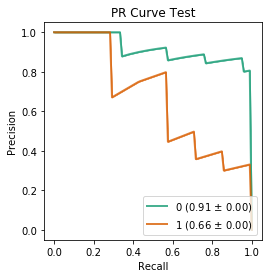

In [81]:
#showing Precision-recall results
fig_comb_lr = plot_result_pr(result_comb_lr,'PR Curve Test')
fig_comb_lr.savefig('ml_analysis/combined_figures/lr_base+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_comb, comb_lr.predict(x_test_comb))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.57


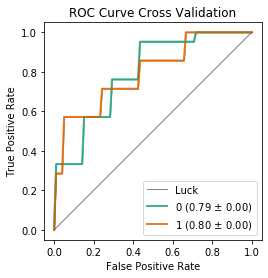

In [82]:
#showing accuracy/ROC results
fig_comb_lr = plot_result_roc(result_comb_lr,'ROC Curve Cross Validation')
fig_comb_lr.savefig('ml_analysis/combined_figures/lr_base+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_comb, comb_lr.predict(x_test_comb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [83]:
#testing RF
result_comb_rf = pd.DataFrame(comb_rf.predict_proba(x_test_comb))
result_comb_rf.columns = comb_rf.classes_
result_comb_rf['Y_TRUE'] = y_test_comb
result_comb_rf['CV'] = 0

Average precision-recall score: 0.28


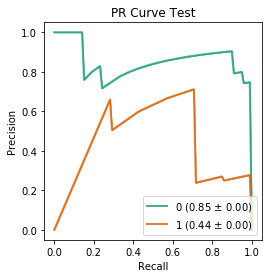

In [84]:
#showing Precision-recall results
fig_comb_rf = plot_result_pr(result_comb_rf,'PR Curve Test')
fig_comb_rf.savefig('ml_analysis/combined_figures/rf_base+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_comb, comb_rf.predict(x_test_comb))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.36


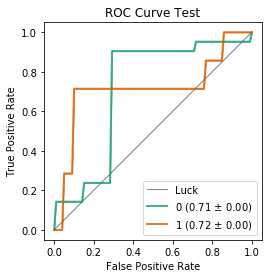

In [85]:
#showing accuracy/ROC results
fig_comb_rf = plot_result_roc(result_comb_rf,'ROC Curve Test')
fig_comb_rf.savefig('ml_analysis/combined_figures/rf_base+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_comb, comb_rf.predict(x_test_comb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

We see a very strong increase in performance for the logistic regression model when adding in the metadata features. Whenever we are working with the seurm data and we add in the meta data features, it appears to cause a loss in performance. To be sure that this is the case, I am going to add the metadata features to each of the combined feature tables to test performance.

## 5. Adding BMI, Gender and Age to Selected Feature Table
Large number of features in the base feature set could be causing the poor performance in the RF model. To see if it is the overall number of features, or if it is the serum and metadata features combined, I will add the metadata features to the selected feature table and test performance

### 5a. CV/Train Model on G1P+G3P Samples

In [86]:
x_train_combSel = pd.concat([x_train_feat1, clin_feat.loc[exp_train.index]],axis=1)
x_train_combSel.gender = pd.factorize(x_train_combSel.gender)[0]
print(x_train_combSel.shape)
x_train_combSel.head(3)

(70, 47)


,027b52f7e9c453c4db513e9a266b6915,0599a329b2d7c76a78d954fc5e1b7a51,01f9feb2a4c23ae6dbbfddd03a30a949,05163992b2900dfeb473198f34648669,05499b638ac0dd75492cc1937ce93aa6,0573a1a5857d294ca17802105e3cae29,05b7691209e78a8527945f6b5b0bcfb4,02c6164bb3acbb7a09c021689f272c1d,022498ce76429e0c6aeebc91003e3cea,06019d17a3cd04f8295187a39b9f7cce,...,04fae26c24c8c1aeb7379099ed4b1584,03e5cb38a914eb96483ca630ad1d9277,022d9bc10db7254d7faa714a29ccfc41,029382fc50a5371c7578fbed50d05276,051b172334bfa84fa54d8a9f529b5e77,06e71388f4d2d3022774b14da2cdc5f7,021cc127437b5c0aede393b33d882fa0,gender,bmi,age
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-BS-002,-0.081804,0.298108,0.716375,-0.571234,-0.574743,-0.669434,-0.525662,-0.129371,-0.405584,2.829393,...,-0.159182,-0.018374,3.771179,2.531452,-0.018890,2.918256,-0.276831,0,28.8,22
TW-BU-002,-0.245010,-0.360257,-0.040684,-0.575890,-0.706262,-0.667621,-0.523605,-0.123324,-0.406862,-0.111131,...,-0.202214,-0.136911,-0.519537,-0.252288,-0.521538,-0.079669,-0.472874,1,23.7,22
TW-BK-001,-0.197466,-0.560658,0.234400,-0.569097,-0.739330,-0.671352,-0.523888,-0.039743,-0.409011,0.801145,...,-0.672067,0.273403,-0.448441,-0.262820,-0.555502,0.031734,-0.449467,1,26.6,60


In [87]:
y_train_combSel = []
for idx in x_train_combSel.index:
    if meta.loc[idx, 'ATTRIBUTE_adv_fibrosis'] == '1':
        y_train_combSel.append(1)
    else:    
        y_train_combSel.append(0)
y_train_combSel = np.array(y_train_combSel)
print(len(y_train_combSel))

70


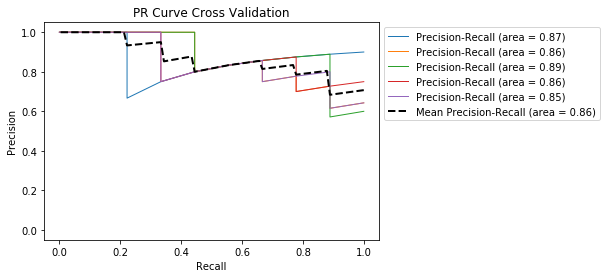

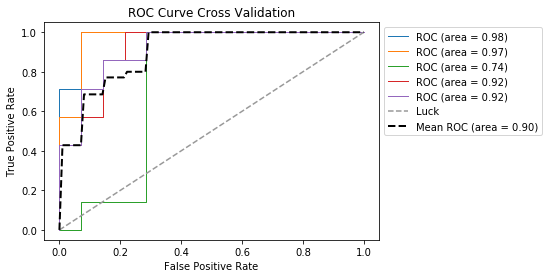

In [88]:
fig_lr = cross_val_pr(0,x_train_combSel,y_train_combSel,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_selected+meta_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_combSel,y_train_combSel,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_selected+meta_cv_roc.pdf',bbox_inches='tight')


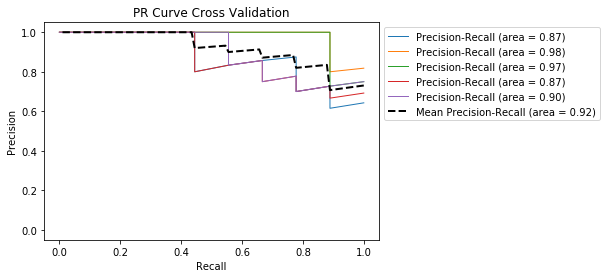

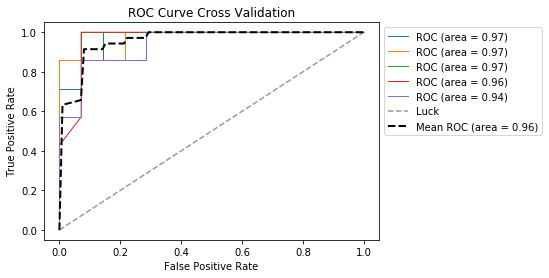

In [89]:
fig_rf = cross_val_pr(1,x_train_combSel,y_train_combSel,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_selected+meta_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_combSel,y_train_combSel,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_selected+meta_cv_roc.pdf',bbox_inches='tight')

In [96]:
#training Log Reg on training data
combSel_lr = LogisticRegression(random_state=0,max_iter=300)
combSel_lr.fit(x_train_combSel, y_train_combSel)

LogisticRegression(max_iter=300, random_state=0)

In [91]:
#training RF on training data
combSel_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
combSel_rf.fit(x_train_combSel, y_train_combSel)
combSel_rf.oob_score_

0.8714285714285714

### 5b. Testing Models on G3R data

In [92]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [93]:
x_test_combSel = pd.concat([x_test_feat1, clin_feat.loc[exp_test.index]],axis=1)
x_test_combSel.gender = pd.factorize(x_test_combSel.gender)[0]
x_test_combSel.shape

(28, 47)

In [94]:
# Preparing the test data
y_test_combSel = []
for idx in x_test_combSel.index:
    if meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '1':
        y_test_combSel.append(1)
    elif meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '0':
        y_test_combSel.append(0)
y_test_combSel = np.array(y_test_combSel)
print(len(y_test_combSel))

28


In [97]:
#testing log reg
result_combSel_lr = pd.DataFrame(combSel_lr.predict_proba(x_test_combSel))
result_combSel_lr.columns = combSel_lr.classes_
result_combSel_lr['Y_TRUE'] = y_test_combSel
result_combSel_lr['CV'] = 0

Average precision-recall score: 0.34


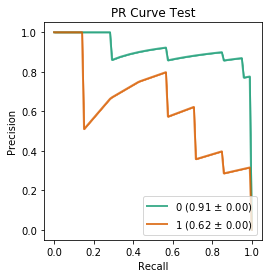

In [98]:
#showing Precision-recall results
fig_comb_lr = plot_result_pr(result_combSel_lr,'PR Curve Test')
fig_comb_lr.savefig('ml_analysis/combined_figures/lr_selected+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_combSel, combSel_lr.predict(x_test_combSel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.57


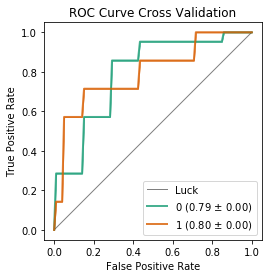

In [99]:
#showing accuracy/ROC results
fig_comb_lr = plot_result_roc(result_combSel_lr,'ROC Curve Cross Validation')
fig_comb_lr.savefig('ml_analysis/combined_figures/lr_selected+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_combSel, combSel_lr.predict(x_test_combSel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [100]:
#testing RF
result_combSel_rf = pd.DataFrame(combSel_rf.predict_proba(x_test_combSel))
result_combSel_rf.columns = combSel_rf.classes_
result_combSel_rf['Y_TRUE'] = y_test_combSel
result_combSel_rf['CV'] = 0

Average precision-recall score: 0.23


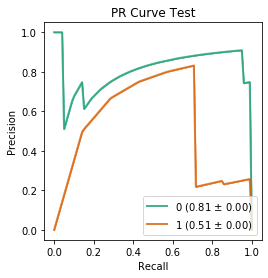

In [101]:
#showing Precision-recall results
fig_comb_rf = plot_result_pr(result_combSel_rf,'PR Curve Test')
fig_comb_rf.savefig('ml_analysis/combined_figures/rf_selected+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_combSel, combSel_rf.predict(x_test_combSel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.25


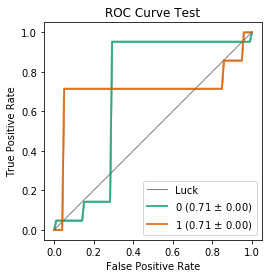

In [102]:
#showing accuracy/ROC results
fig_comb_rf = plot_result_roc(result_combSel_rf,'ROC Curve Test')
fig_comb_rf.savefig('ml_analysis/combined_figures/rf_selected+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_combSel, combSel_rf.predict(x_test_combSel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

Adding the meta data features to the selected feature set did not do much to improve either machine learning model. Typically reducing features does not help LR, but reducing in RF does. Could still be that combining the serum and the metadata features is hampering the performance of the RF model.

## 6. Adding BMI, Gender and Age to Further Selected Feature Table
Final check to see if the further selected combined feature table can be improved by adding metadata features.

### 6a. CV/Train Model on G1P+G3P Samples

In [104]:
x_train_combFsel = pd.concat([x_train_feat2, clin_feat.loc[exp_train.index]],axis=1)
x_train_combFsel.gender = pd.factorize(x_train_combFsel.gender)[0]
print(x_train_combFsel.shape)
x_train_combFsel.head(3)

(70, 19)


,027b52f7e9c453c4db513e9a266b6915,01f9feb2a4c23ae6dbbfddd03a30a949,0599a329b2d7c76a78d954fc5e1b7a51,0573a1a5857d294ca17802105e3cae29,05b7691209e78a8527945f6b5b0bcfb4,04594b884377a2bd2550c5d4d956e08b,06019d17a3cd04f8295187a39b9f7cce,02c6164bb3acbb7a09c021689f272c1d,05499b638ac0dd75492cc1937ce93aa6,05163992b2900dfeb473198f34648669,0074f0d3d22016bcdf28ee53c8a5062b,02fb4d45edee84cbdf683f6305cedab8,022498ce76429e0c6aeebc91003e3cea,04aed1229920f03c64ec6efd65afa969,034818a2509951b61eb3afbbc33dede4,01f940cc9606a206fc0f5f4be686142a,gender,bmi,age
sampleid,,,,,,,,,,,,,,,,,,,
TW-BS-002,-0.081804,0.716375,0.298108,-0.669434,-0.525662,0.172935,2.829393,-0.129371,-0.574743,-0.571234,-0.052525,-0.750834,-0.405584,-0.715710,-0.485720,-0.301339,0,28.8,22
TW-BU-002,-0.245010,-0.040684,-0.360257,-0.667621,-0.523605,0.384241,-0.111131,-0.123324,-0.706262,-0.575890,-0.064788,-0.746470,-0.406862,2.410299,-0.392838,-0.289906,1,23.7,22
TW-BK-001,-0.197466,0.234400,-0.560658,-0.671352,-0.523888,1.002192,0.801145,-0.039743,-0.739330,-0.569097,-0.130301,-0.745081,-0.409011,1.383060,-0.375340,-0.301339,1,26.6,60


In [105]:
y_train_combFsel = []
for idx in x_train_combFsel.index:
    if meta.loc[idx, 'ATTRIBUTE_adv_fibrosis'] == '1':
        y_train_combFsel.append(1)
    else:    
        y_train_combFsel.append(0)
y_train_combFsel = np.array(y_train_combFsel)
print(len(y_train_combFsel))

70


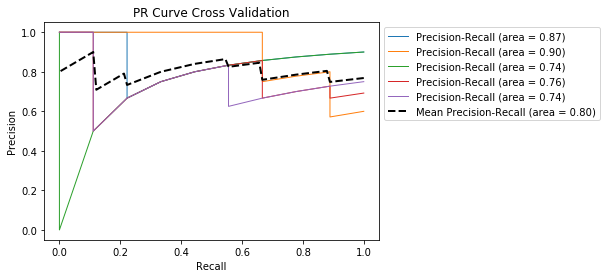

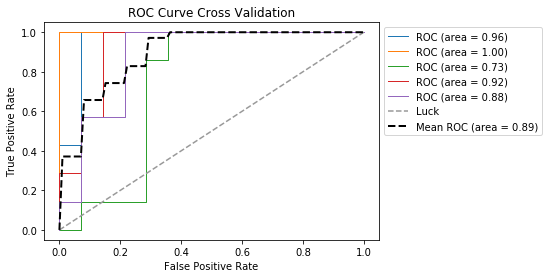

In [106]:
fig_lr = cross_val_pr(0,x_train_combFsel,y_train_combFsel,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_fselected+meta_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_combFsel,y_train_combFsel,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/combined_figures/lr_fselected+meta_cv_roc.pdf',bbox_inches='tight')


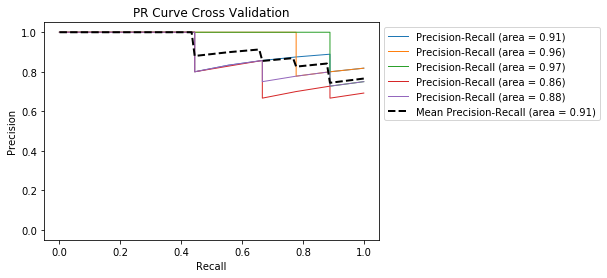

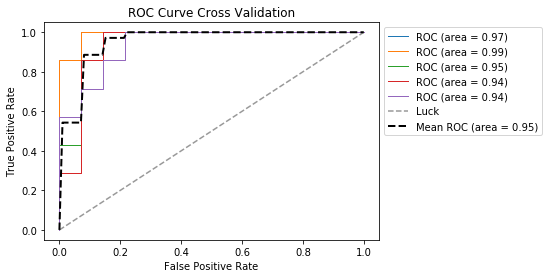

In [107]:
fig_rf = cross_val_pr(1,x_train_combFsel,y_train_combFsel,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_fselected+meta_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_combFsel,y_train_combFsel,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/combined_figures/rf_fselected+meta_cv_roc.pdf',bbox_inches='tight')

In [108]:
#training Log Reg on training data
combFsel_lr = LogisticRegression(random_state=0,max_iter=300)
combFsel_lr.fit(x_train_combFsel, y_train_combSel)

LogisticRegression(max_iter=300, random_state=0)

In [109]:
#training RF on training data
combFsel_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
combFsel_rf.fit(x_train_combFsel, y_train_combFsel)
combFsel_rf.oob_score_

0.9142857142857143

### 6b. Testing Models on G3R data

In [110]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [111]:
x_test_combFsel = pd.concat([x_test_feat2, clin_feat.loc[exp_test.index]],axis=1)
x_test_combFsel.gender = pd.factorize(x_test_combFsel.gender)[0]
x_test_combFsel.shape

(28, 19)

In [112]:
# Preparing the test data
y_test_combFsel = []
for idx in x_test_combFsel.index:
    if meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '1':
        y_test_combFsel.append(1)
    elif meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '0':
        y_test_combFsel.append(0)
y_test_combFsel = np.array(y_test_combFsel)
print(len(y_test_combFsel))

28


In [113]:
#testing log reg
result_combFsel_lr = pd.DataFrame(combFsel_lr.predict_proba(x_test_combFsel))
result_combFsel_lr.columns = combFsel_lr.classes_
result_combFsel_lr['Y_TRUE'] = y_test_combFsel
result_combFsel_lr['CV'] = 0

Average precision-recall score: 0.41


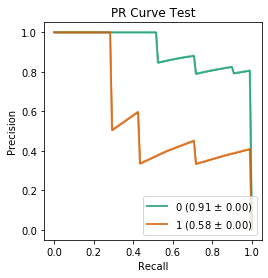

In [114]:
#showing Precision-recall results
fig_comb_lr = plot_result_pr(result_combFsel_lr,'PR Curve Test')
fig_comb_lr.savefig('ml_analysis/combined_figures/lr_fselected+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_combFsel, combFsel_lr.predict(x_test_combFsel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.64


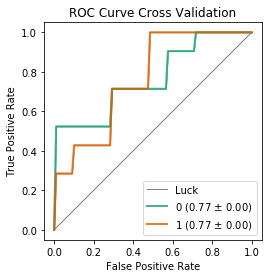

In [115]:
#showing accuracy/ROC results
fig_comb_lr = plot_result_roc(result_combFsel_lr,'ROC Curve Cross Validation')
fig_comb_lr.savefig('ml_analysis/combined_figures/lr_fselected+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_combFsel, combFsel_lr.predict(x_test_combFsel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [116]:
#testing RF
result_combFsel_rf = pd.DataFrame(combFsel_rf.predict_proba(x_test_combFsel))
result_combFsel_rf.columns = combFsel_rf.classes_
result_combFsel_rf['Y_TRUE'] = y_test_combFsel
result_combFsel_rf['CV'] = 0

Average precision-recall score: 0.25


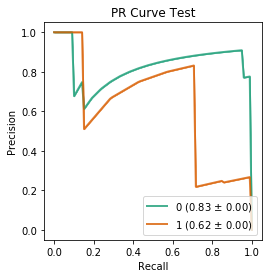

In [117]:
#showing Precision-recall results
fig_comb_rf = plot_result_pr(result_combFsel_rf,'PR Curve Test')
fig_comb_rf.savefig('ml_analysis/combined_figures/rf_fselected+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_combFsel, combFsel_rf.predict(x_test_combFsel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


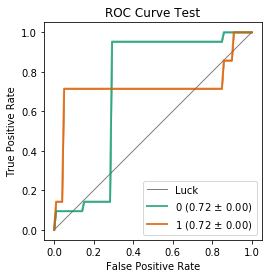

In [118]:
#showing accuracy/ROC results
fig_comb_rf = plot_result_roc(result_combFsel_rf,'ROC Curve Test')
fig_comb_rf.savefig('ml_analysis/combined_figures/rf_fselected+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_combFsel, combFsel_rf.predict(x_test_combFsel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))